In [15]:
%matplotlib inline

import time
import datetime
from os import listdir
from os import walk
import gc

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patheffects as PathEffects
from matplotlib import colors
import numpy as np
import pandas as pd
import sunpy
import sunpy.map
import pyfits
import csv
from StringIO import StringIO
import requests
import urllib2

In [2]:
def getXrtPointings(time1,time2,first=True):
    '''Arguments are datetime objects
    time1 must be prior to time2
    Works across day, month, and year boundaries between time1 and time2
    Returns list of lists: [[xcen,ycen,naxis1,naxis2,plate_scl],...]'''
    
    years = []
    for year in listdir('/archive/hinode/xrt/level0/'):
        if year >= str(time1.year) and year <= str(time2.year):
            years.append(year)
    
    months = []
    for year in years:
        gen = (month for month in listdir('/archive/hinode/xrt/level0/' + year) if month in ['01','02','03','04','05','06','07','08','09','10','11','12'])
        for month in gen:
            time = datetime.datetime.strptime(month+year,'%m%Y')
            if time >= time1.replace(day=1,hour=0,minute=0,second=0,microsecond=0) and time <= time2.replace(day=1,hour=0,minute=0,second=0,microsecond=0):
                months.append(year + '/' + month)
    
    days = []
    for month in months:
        for day in listdir('/archive/hinode/xrt/level0/' + month):
            time = datetime.datetime.strptime(month+day,'%Y/%m%d')
            if time >= time1.replace(hour=0,minute=0,second=0,microsecond=0) and time <= time2.replace(hour=0,minute=0,second=0,microsecond=0):
                days.append(month + '/' + day)
    
    hours = []
    for day in days:
        for hour in listdir('/archive/hinode/xrt/level0/' + day):
            time = datetime.datetime.strptime(day + hour,'%Y/%m/%dH%H00')
            if time >= time1.replace(minute=0,second=0,microsecond=0) and time <= time2.replace(minute=0,second=0,microsecond=0):
                hours.append(day + '/' + hour)
        
    metadata = [] #list of lists: [[xcen,ycen,naxis1,naxis2,plate_scl],...]
    
    for hour in hours:
        for root, dirs, files in walk('/archive/hinode/xrt/level0/' + hour):
            for e in files:
                time = datetime.datetime.strptime(e[:18],'XRT%Y%m%d_%H%M%S')
                if time > time1 and time < time2:
                    a = pyfits.open(root + '/' + e)
                    if a[0].header['chip_sum'] != 8:
                        if (a[0].header['ec_fw2_'] != 'Gband') and (a[0].header['ec_fw1_'] != a[0].header['ec_fw2_']):
                            if first:
                                return [[a[0].header['xcen'],a[0].header['ycen'],a[0].header['naxis1'],a[0].header['naxis2'],a[0].header['platescl']]];
                            metadata.append([a[0].header['xcen'],a[0].header['ycen'],a[0].header['naxis1'],a[0].header['naxis2'],a[0].header['platescl']])
                    a.close()
    return metadata;

def groupFlareResData(flares):
    '''Argument is list of lists from getXrtPointings - the first science image from each flare response with the
    number of science images appended
    Returns list of lists - each list has averaged xcen,ycen,naxis1,naxis2, and platescl data and a final element
    indicating the number of group members'''
    
    flareGroups = []
    
    for flare in flares:
        inGroup = False
        for group in flareGroups:
            if abs(flare[0]-group[0]/group[6]) < 150 and abs(flare[1]-group[1]/group[6]) < 150:
                inGroup = True
                for i in range(6):
                    group[i] = group[i] + flare[i]
                group[6] = group[6] + 1
        if not inGroup:
            flare.append(1)
            flareGroups.append(flare)
    
    for group in flareGroups:
        for i in range(5):
            group[i] = group[i]/group[6]
    
    return flareGroups

def groupFlareCatData(flares):
    '''Argument is list of tuples for flares in desired time range: [(t_start,x,y,class),...]
    returns list of group lists: [[num,x_ave,y_ave,class,class,class...],...]
    class strings are ordered first to last by t_start values'''
    flareGroups = []
    
    for flare in flares:
        inGroup = False
        for group in flareGroups:
            if abs(flare[1]-group[1]/group[0]) < 200 and abs(flare[2]-group[2]/group[0]) < 200:
                inGroup = True
                group[0] = group[0] + 1
                group[1] = group[1] + flare[1]
                group[2] = group[2] + flare[2]
                group.append(flare[3])
        if not inGroup:
            flareGroups.append([1,flare[1],flare[2],flare[3]])

    for group in flareGroups:
        group[1] = group[1]/group[0]
        group[2] = group[2]/group[0]
    
    return flareGroups

In [3]:
def split_and_purge(in_str, delim=None, purge=["", "+"]):
    """Splits a string into an array of strings, removing unwanted strings."""
    pieces = []
    if delim is None:
        pieces = in_str.split()  # Split for both spaces and tabs.
    else:
        pieces = in_str.split(delim)
    return [piece for piece in pieces if piece not in purge]

def parse_events(events_file):
    """Parses an Hinode pointing file into a pandas-friendly form."""
    # Split into lines.
    lines = split_and_purge(events_file, delim="\n")

    # Throw away the first 8 lines. We do not need the info contained in them.
    lines = lines[8:]

    if len(lines) < 2:
        return ""

    # I manually set the column titles, as the formatting they come in is confusing, with titles spanning 2 lines
    title_row = ['Repoint','Start Time', 'Tracking Curve','Offset-X','Offset-Y','Xpointing','Ypointing','Notes']

    # Get the rows.
    rows = []
    for line in lines[:]:
        items = split_and_purge(line)

        # Too few items.
        if len(items) < 7:
            continue

        # The .join combines 2 items into one (for example making the day and time into one row)
        rows.append([" ".join(items[:2])] + [" ".join(items[2:4])] + items[4:7] + items[8:10]+[" ".join(items[10:])])

    # Create csv.
    strio = StringIO()
    writer = csv.writer(strio)
    writer.writerows([title_row] + rows)
    return strio.getvalue()

def parseTimelineInfo(page):
    lines = split_and_purge(page, delim='\n')
    lines = lines[11:-5]
    output = []
    for line in lines[:]:
        if 'Plan' in line:
            output.append(line.replace('>','<').split('<')[4])
    return output

def parseFlareResInfo(page):
    '''Returns document as a list of tuples of datetime objects: [(t_start,t_end),...]'''
    lines = split_and_purge(page,delim='\n')
    output = []
    for line in lines[7:]:
        times = line.split()
        t1 = datetime.datetime.strptime(times[0],'%Y-%m-%dT%H:%M:%S')
        t2 = datetime.datetime.strptime(times[1],'%Y-%m-%dT%H:%M:%S')
        output.append((t1,t2))
    return output;

def parseHinodeFlareCat(f):
    '''Returns a list of tuples (tStart,x,y,class) for all flares in catalogue'''
    lines = split_and_purge(f,delim='\n')
    output = []
    
    for line in lines[1:]:
        row = line.split(',')
        try:
            output.append((datetime.datetime.strptime(row[1],'%Y/%m/%d %H:%M'),int(row[6]),int(row[7]),row[5]))
        except ValueError:
            pass

    return output;

In [4]:
def getPointingFileName(page):
    lines = split_and_purge(page, delim='\n')
    for line in lines:
        if 're-point_' in line:
            return line.replace('re-point_','.txt').split('.txt')[1]

def getPointingFileInfo(time,offset):
    '''Arguments are a datetime object and a timedelta object, respectively
    Returns list of pandas dataframes'''
    
    t = time.replace(minute=0,second=0,microsecond=0)
    timelines = urllib2.urlopen('https://xrt.cfa.harvard.edu/missionops/timelines/')
    strio = StringIO(requests.get('https://xrt.cfa.harvard.edu/missionops/timelines/').content)
    timelineFile = strio.read()
    info = parseTimelineInfo(timelineFile)
    
    dates = []
    for date in info:
        dates.append(datetime.datetime.strptime(date[:10],'%Y/%m/%d'))
    
    fileDates = []
    
    i = 0
    while fileDates == []: #sequential search for starting date of relevant pointing file
        if dates[i]-(t-offset) < datetime.datetime.resolution:
            fileDates.append(dates[i])
            if i > 0:
                fileDates.append(dates[i-1])
            if i < len(dates):
                fileDates.append(dates[i+1])
        i = i + 1
    
    #checks for existence of a second relevant pointing file
    #if dates[i-2].replace(hour=4) > (t-offset) and dates[i-1].replace(hour=4) < (t+offset):
     #   fileDates.append(dates[i-2])
    
    output = []
    for date in fileDates:
        url = 'http://xrt.cfa.harvard.edu/missionops/timelines/' + date.strftime('%Y%m%d') + '_Plan/' 
        webPage = urllib2.urlopen(url)
        strio = StringIO(requests.get(url).content)
        url = 'http://xrt.cfa.harvard.edu/missionops/timelines/' + date.strftime('%Y%m%d') + '_Plan/re-point_' + getPointingFileName(strio.read())+'.txt'
        f = urllib2.urlopen(url)
        strio = StringIO(requests.get(url).content)
        output.append(pd.read_csv(StringIO(parse_events(strio.read()))))
        f.close()
        webPage.close()
        del strio
    
    timelines.close()
    del info, dates, fileDates
    
    return output

def getFlareModeInfo(time1,time2):
    '''Arguments are datetime objects. time1 must be prior to time2
    Returns list of tuples of times (t_start,t_end) of flare responses between time1 and time2'''
    t = time.time()
    f = urllib2.urlopen('https://xrt.cfa.harvard.edu/missionops/flare_trigger_list/xrt_flare_responses.txt')
    strio = StringIO(requests.get('https://xrt.cfa.harvard.edu/missionops/flare_trigger_list/xrt_flare_responses.txt').content)
    flareFile = strio.read()
    info = parseFlareResInfo(flareFile)
    
    output = []
    for flare in info:
        if time1<flare[0] and flare[0]<time2:
            output.append(flare)
    
    f.close()
    del strio, flareFile, info
    
    return output;

def getHinodeFlareCat(time1,time2):
    '''Arguments are datetime objects. time1 must be priot to time2
    returns list of tuples: [(tStart,x,y,class),...]'''
    f = urllib2.urlopen('http://st4a.stelab.nagoya-u.ac.jp/hinode_flare/csv/all_event.csv')
    strio = StringIO(requests.get('http://st4a.stelab.nagoya-u.ac.jp/hinode_flare/csv/all_event.csv').content)
    catalog = strio.read()
    info = parseHinodeFlareCat(catalog)
    
    output = []
    for e in info:
        if time1 < e[0] and e[0] < time2:
            output.append(e)
    
    f.close()
    del strio, catalog, info
    
    return output

In [5]:
def getSynoptics(time1,time2):
    '''Arguments are datetime objects
    time1 must be prior to time2
    Works across day, month, and year boundaries between time1 and time2
    Returns list of strings (paths to synoptic FITS files)'''
    
    years = []
    for year in listdir('/archive/hinode/xrt/level2/synoptics/'):
        if year >= str(time1.year) and year <= str(time2.year):
            years.append(year)
    
    months = []
    for year in years:
        gen = (month for month in listdir('/archive/hinode/xrt/level2/synoptics/' + year) if month in ['01','02','03','04','05','06','07','08','09','10','11','12'])
        for month in gen:
            time = datetime.datetime.strptime(month+year,'%m%Y')
            if time >= time1.replace(day=1,hour=0,minute=0,second=0,microsecond=0) and time <= time2.replace(day=1,hour=0,minute=0,second=0,microsecond=0):
                months.append(year + '/' + month)
    
    days = []
    for month in months:
        for day in listdir('/archive/hinode/xrt/level2/synoptics/'+ month):
            time = datetime.datetime.strptime(month+day,'%Y/%m%d')
            if time >= time1.replace(hour=0,minute=0,second=0,microsecond=0) and time <= time2.replace(hour=0,minute=0,second=0,microsecond=0):
                days.append(month + '/' + day)
    
    hours = []
    for day in days:
        for hour in listdir('/archive/hinode/xrt/level2/synoptics/'+ day):
            time = datetime.datetime.strptime(day+hour,'%Y/%m/%dH%H00')
            if time >= time1.replace(minute=0,second=0,microsecond=0) and time <= time2.replace(minute=0,second=0,microsecond=0):
                hours.append(day + '/' + hour)
                
    paths = []
    
    for hour in hours:
        for root, dirs, files in walk('/archive/hinode/xrt/level2/synoptics/'+hour):
            for e in files:
                if e[-5:] == '.fits':
                    f = pyfits.open(root + '/' + e)
                    if f[0].header['ec_fw2_'] == 'Al_mesh':
                        paths.append(root + '/' + e)
                    f.close()
                 
    return paths;

In [216]:
def displaySynoptic(path):
    '''path is string of the file's path
    Displays requested synoptic with annotations and boxes'''

    file1 = pyfits.open(path)
    date_obs = datetime.datetime.strptime(file1[0].header['date_obs'],'%Y-%m-%dT%H:%M:%S.%f')
    offset = datetime.timedelta(hours=6)
    
    dfList = getPointingFileInfo(date_obs,offset)
    pointingInfo = [] #list of tuples: [(startTime,trackingCurve),...]
    for df in dfList:
        pointingInfo = pointingInfo + [(datetime.datetime.strptime(time,'%Y/%m/%d %H:%M:%S'),curve) for time,curve,repoint,x,y,notes in zip(df['Start Time'],df['Tracking Curve'],df['Repoint'],df['Xpointing'],df['Ypointing'],df['Notes']) if repoint == 'ORe-point Start' and 'quadrant' not in notes]
    
    startTimes = []
    usedCurves = []
    for i in range(len(pointingInfo)):
        
        if pointingInfo[i][0] > date_obs-offset and pointingInfo[i][0] < date_obs+offset and pointingInfo[i][1] not in usedCurves:
            startTimes.append(pointingInfo[i][0])
            if pointingInfo[i][1] != '0':
                usedCurves.append(pointingInfo[i][1])
                
        elif i < len(pointingInfo)-1 and pointingInfo[i+1][0] > date_obs-offset and pointingInfo[i+1][0] < date_obs+offset and pointingInfo[i][1] not in usedCurves:
            startTimes.append(date_obs-offset)
            if pointingInfo[i][1] != '0':
                usedCurves.append(pointingInfo[i][1])
                       
    
    metadata= []
    
    for i in range(len(startTimes)):
        if i < len(startTimes)-1:
            try:
                metadata.append(getXrtPointings(startTimes[i],startTimes[i+1])[0])  #pointingTime+datetime.timedelta(minutes=60))[0])
            except IndexError:
                pass
        else:
            try:
                metadata.append(getXrtPointings(startTimes[i],date_obs+offset)[0])
            except IndexError:
                pass
    fig = plt.figure(figsize=(15,15),frameon=False)
    ax = fig.add_subplot(111)
    
    for e in metadata:
        if e[2] == e[3]:
            xLeft = e[0]-(e[2]*.97*e[4])/2
            yBottom = e[1]-(e[3]*.97*e[4])/2
            xSize = e[2]*e[4]*.97
            ySize = e[3]*e[4]*.97
            ax.add_patch(Rectangle((xLeft,yBottom), xSize, ySize, fill=False,color='white',linewidth=3,
                                        path_effects=[PathEffects.withStroke(linewidth=5,foreground="black")]))
    
    flareResponses = [] #flares that triggered XRT flare response
    for flare in getFlareModeInfo(date_obs-offset,date_obs+offset):
        flareImages = getXrtPointings(flare[0],flare[1],first=False)
        if flareImages != []:
            flareImages[0].append(len(flareImages))
            flareResponses.append(flareImages[0])
    
    for group in groupFlareResData(flareResponses):
        xLeft = group[0]-(group[2]*.97*group[4])/2
        yBottom = group[1]-(group[3]*.97*group[4])/2
        xSize = group[2]*group[4]*.97
        ySize = group[3]*group[4]*.97
        if group[6] == 1:
            label = str(group[5])
        else:
            label = str(group[6])+'-'+str(group[5])
            
        ax.add_patch(Rectangle((xLeft,yBottom), xSize, ySize, fill=False,color='yellow',linewidth=3,
                                        path_effects=[PathEffects.withStroke(linewidth=5,foreground="black")]))
        
        if xLeft > -1075 and yBottom > -1075:
            ax.text(xLeft+10,yBottom+10,label,color='yellow',size=28,
                     path_effects=[PathEffects.withStroke(linewidth=2,foreground="black")])
        elif xLeft < -1075 and yBottom > -1075:
            ax.text(xLeft+xSize-38*len(label)-10,yBottom+10,label,color='yellow',size=28,
                     path_effects=[PathEffects.withStroke(linewidth=2,foreground="black")])
        else:
            ax.text(xLeft+10,yBottom+ySize-38*len(label)-10,label,color='yellow',size=28,
                     path_effects=[PathEffects.withStroke(linewidth=2,foreground="black")])
    
    global flareCatalog
    flares = []
    for flare in flareCatalog:
        if date_obs-offset < flare[0] and flare[0] < date_obs+offset:
            flares.append(flare)
    
    for group in groupFlareCatData(flares):
        xLeft = group[1] - 20*len(group[3])
        yBottom = group[2] - 40*group[0]
        label = group[3]
        for flareClass in group[4:]:
            label = label +'\n'+flareClass

        ax.text(xLeft,yBottom,label,color='yellow',size=28,
                 path_effects=[PathEffects.withStroke(linewidth=2,foreground="black")])
    
    map1 = sunpy.map.Map(np.log10(np.maximum(file1[0].data,1)),dict(file1[0].header))

    map1.plot(vmin=0.5,vmax=4)


    ax.text(-1040,890,'XRT',color='white',size=56,
                                        path_effects=[PathEffects.withStroke(linewidth=2,foreground="black")])
    ax.text(-1040,820,file1[0].header['ec_fw1_'] + ' / ' + file1[0].header['ec_fw2_'],color='white',size=28,
                                        path_effects=[PathEffects.withStroke(linewidth=2,foreground="black")])
    ax.text(-1040,-1015,file1[0].header['date_obs'],color='white',size=28,
                                        path_effects=[PathEffects.withStroke(linewidth=2,foreground="black")])
    
    fig.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    
    fig.savefig('/home/gwoelki/'+datetime.datetime.strftime(date_obs,'%Y-%m-%dT%H%M%S')+'.jpg',
                dpi=96)
    #plt.show()
    fig.clf()
    plt.close(fig)
    file1.close()
    gc.collect()

    return 0;

In [187]:
t_f = datetime.datetime.utcnow() #datetime.datetime.strptime('2015-06-10 06:00','%Y-%m-%d %H:%M')
t_i = t_f - datetime.timedelta(days=365)

flareCatalog = getHinodeFlareCat(t_i,t_f)

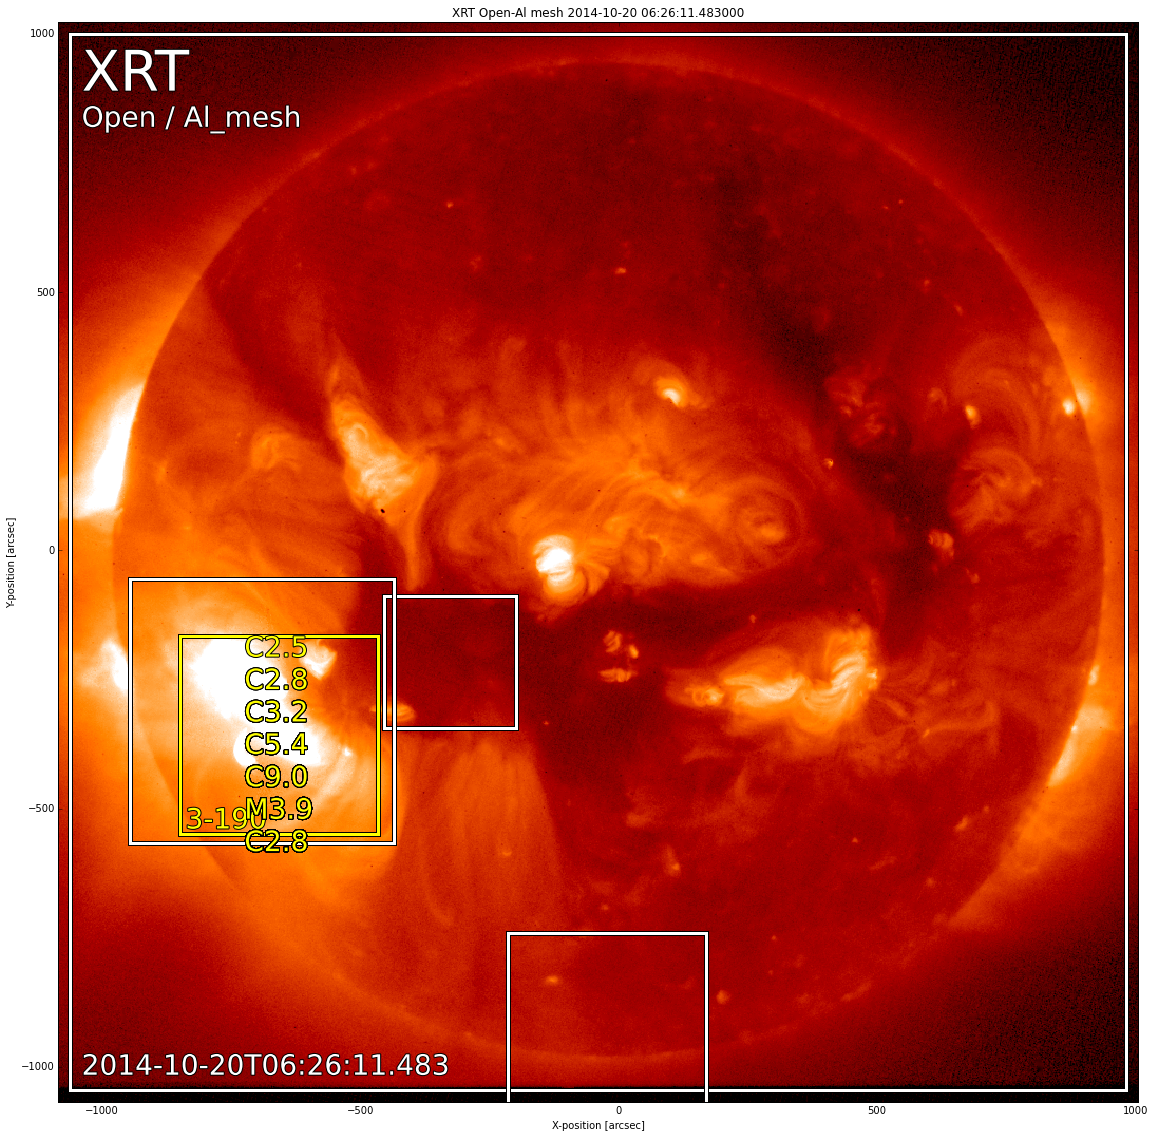

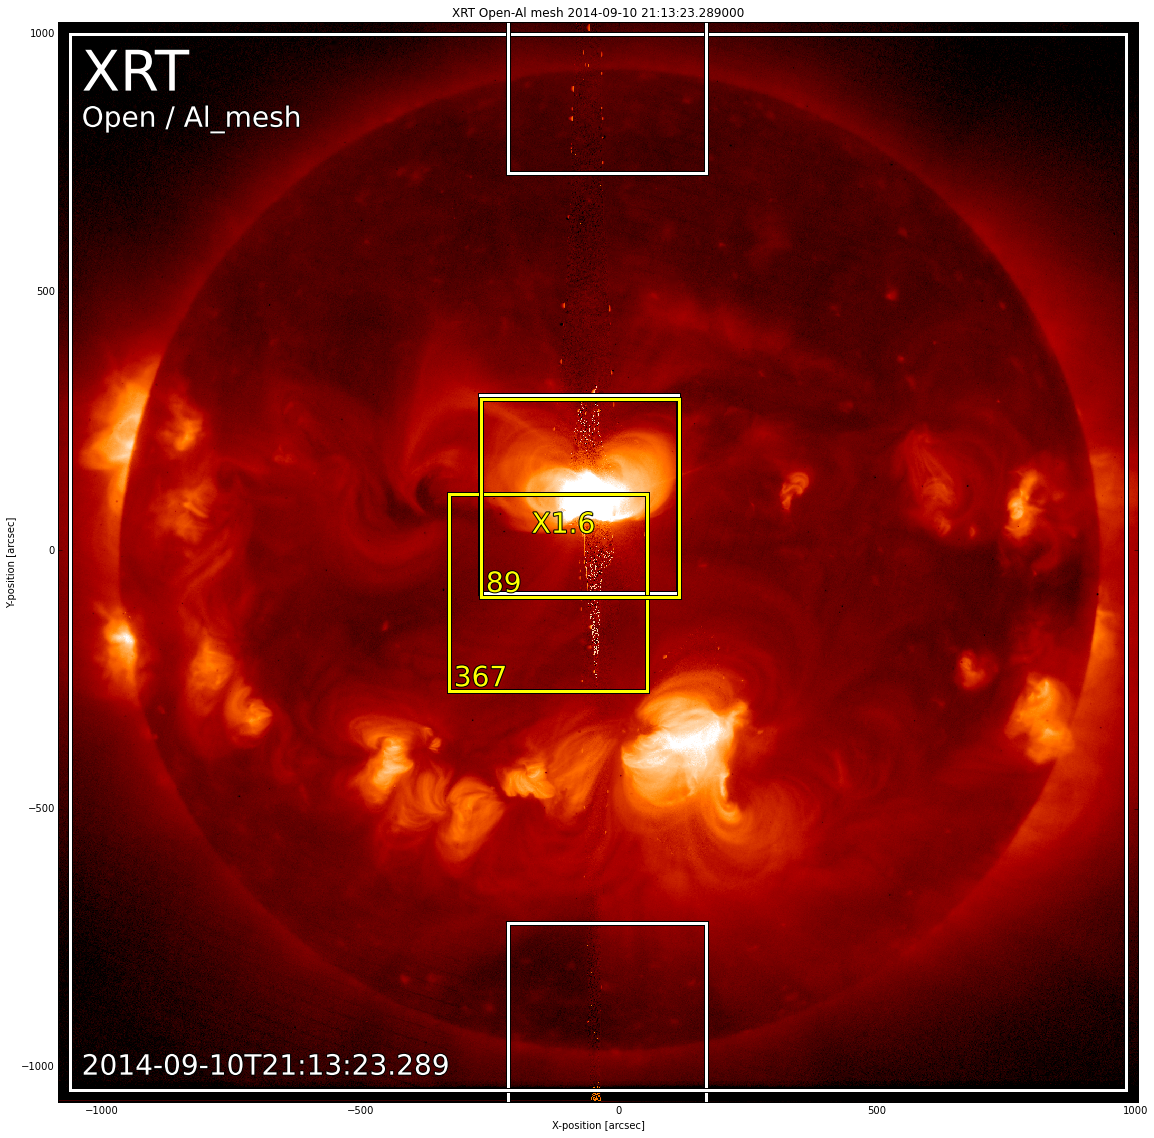

0

In [214]:
displaySynoptic('/archive/hinode/xrt/level2/synoptics/2014/10/20/H0600/comp_XRT20141020_062611.4.fits')
displaySynoptic('/archive/hinode/xrt/level2/synoptics/2014/09/10/H2100/comp_XRT20140910_211323.2.fits ')

In [0]:
for synoptic in getSynoptics(t_i,t_f):
    displaySynoptic(synoptic)
    #gc.collect()
    print 'here'